In [8]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection    import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing     import OneHotEncoder, StandardScaler
from sklearn.compose           import ColumnTransformer
from sklearn.pipeline          import Pipeline
from lightgbm                  import LGBMRegressor

# ── 1) 데이터 로드 ─────────────────────────────────────────
BASE   = "/Users/gun/Desktop/미래에셋 AI 공모전/data"
REG_FP = os.path.join(BASE, "module_datasets", "regression.csv")

df = pd.read_csv(REG_FP, parse_dates=["rcept_dt"], dtype={"stock_code":str})

# ── 2) 타깃 설정(ret_1d) ────────────────────────────────────
df = df.dropna(subset=["ret_1d"]).reset_index(drop=True)
target = "ret_1d"
y = df[target]

# ── 3) 피처 분리 ────────────────────────────────────────────
X = df.drop(columns=[target, "stock_code", "rcept_dt", "corp_name"])

# ── 4) 범주형 vs. 수치형 구분 ───────────────────────────────
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

# ── 5) 전처리 & 모델 파이프라인 ─────────────────────────────
preprocessor = ColumnTransformer([
    ("scale", StandardScaler(), num_cols),
    ("ohe",   OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
], remainder="drop")

pipe = Pipeline([
    ("pre", preprocessor),
    ("reg", LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        random_state=42,
        n_jobs=-1
    ))
])

# ── 6) 시계열 분할 교차검증 ─────────────────────────────────
tscv = TimeSeriesSplit(n_splits=5)
r2_scores = cross_val_score(
    pipe, X, y,
    cv=tscv,
    scoring="r2",
    n_jobs=-1
)

print("▶ ret_1d 회귀 R² (5-fold CV): "
      f"{r2_scores.mean():.4f} ± {r2_scores.std():.4f}")

# ── 7) 최종 학습/저장 ──────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)
pipe.fit(X_train, y_train)
print("▶ Test  R² :", pipe.score(X_test, y_test))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2736
[LightGBM] [Info] Total Bins 2831
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Number of data points in the train set: 2198, number of used features: 44
[LightGBM] [Info] Number of data points in the train set: 4395, number of used features: 70
[LightGBM] [Info] Total Bins 2944
[LightGBM] [Info] Number of data points in the train set: 6592, number of used features: 82
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead o

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Framework

▶ ret_1d 회귀 R² (5-fold CV): 0.5087 ± 0.0743
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3002
[LightGBM] [Info] Number of data points in the train set: 10546, number of used features: 104
[LightGBM] [Info] Start training from score 0.000727
▶ Test  R² : 0.5459339521388621


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [10]:
import os
import time
import warnings
import concurrent.futures

import pandas as pd
import numpy as np
import yfinance as yf
from sentence_transformers import SentenceTransformer
import ta
from requests.exceptions import JSONDecodeError as RequestsJSONDecodeError
from json.decoder        import JSONDecodeError as BuiltinJSONDecodeError

# ─────────────────────────────────────────────────────────────────────────────
# 0️⃣ 경로·상수 설정
BASE        = "/Users/gun/Desktop/미래에셋 AI 공모전/data"
REG_FP      = os.path.join(BASE, "module_datasets", "regression.csv")
DIV_JSONL   = os.path.join(BASE, "dividend_with_text.jsonl")
FULL_HIST   = os.path.join(BASE, "full_price_history.csv")
SECTOR_FP   = os.path.join(BASE, "sector_info.csv")
OUT_FP      = os.path.join(BASE, "module_datasets", "regression_enriched.csv")
WINDOW      = 30
MAX_WORKERS = 8

warnings.filterwarnings("ignore")

# ─────────────────────────────────────────────────────────────────────────────
# 1️⃣ 회귀 원본 CSV + JSONL 로드
df     = pd.read_csv(REG_FP, parse_dates=["rcept_dt"], dtype={"stock_code":str})
df_txt = pd.read_json(DIV_JSONL, lines=True, dtype={"stock_code":str})

# 날짜 문자열 → datetime
df_txt["rcept_dt"] = pd.to_datetime(
    df_txt["rcept_dt"].astype(str),
    format="%Y%m%d",
    errors="coerce"
)

# 텍스트 컬럼 결정
if "text" in df_txt.columns:
    TEXT_COL = "text"
elif "html" in df_txt.columns:
    TEXT_COL = "html"
else:
    raise KeyError("JSONL에 'text' 또는 'html' 컬럼이 없습니다.")

# ─────────────────────────────────────────────────────────────────────────────
# 2️⃣ 주가·섹터 데이터 로드 및 섹터별 평균 수익률 맵
df_full = pd.read_csv(FULL_HIST, parse_dates=["date"], dtype={"stock_code":str})
df_sec  = pd.read_csv(SECTOR_FP, dtype=str)
df_sec["stock_code"] = df_sec["stock_code"].str.zfill(6)

df_full = df_full.merge(df_sec[["stock_code","sector"]], on="stock_code", how="left")
df_full["ret"] = df_full.groupby("stock_code")["close"].pct_change().fillna(0)
sector_ret_map = df_full.groupby(["sector","date"])["ret"].mean().to_dict()

# ─────────────────────────────────────────────────────────────────────────────
# 3️⃣ KOSPI 일별 수익률 맵 (yfinance 로 대체)
try:
    kospi_df = yf.download("^KS11", start=df_full.date.min(), end=df_full.date.max())
    kospi_ret = kospi_df["Close"].pct_change().fillna(0)
    kospi_map = { idx.date(): r for idx,r in kospi_ret.items() }
except Exception:
    kospi_map = {}

# ─────────────────────────────────────────────────────────────────────────────
# 4️⃣ 텍스트 임베딩 모델
embed_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# ─────────────────────────────────────────────────────────────────────────────
# 5️⃣ 종목별 히스토리 맵
df_full.sort_values(["stock_code","date"], inplace=True)
hist_map = {
    code:grp.reset_index(drop=True)
    for code,grp in df_full.groupby("stock_code")
}

# ─────────────────────────────────────────────────────────────────────────────
# 6️⃣ yfinance 정보 조회 함수
def get_yf_info(code, retries=3):
    for _ in range(retries):
        try:
            return yf.Ticker(code + ".KS").info
        except (RequestsJSONDecodeError, BuiltinJSONDecodeError, Exception):
            time.sleep(0.5)
    return {}

# ─────────────────────────────────────────────────────────────────────────────
# 7️⃣ 한 행씩 피처 생성
def process_row(item):
    _, row = item
    code, dt, sector = row.stock_code, row.rcept_dt, row.sector
    orig = hist_map.get(code)
    if orig is None:
        return None

    # DataFrame 복사 + 필수 컬럼 보정
    hist = orig.copy()
    for col in ["open","high","low"]:
        if col not in hist.columns:
            hist[col] = hist["close"]

    # (1) 영업일 보정
    pos = hist["date"].searchsorted(dt)
    if pos >= len(hist) or hist.loc[pos,"date"] < dt:
        fut = hist["date"][hist["date"] >= dt]
        if fut.empty:
            return None
        pos = hist["date"].searchsorted(fut.iloc[0])

    # (2) 전일 대비 가격 변화
    gap_before = (hist["close"].iloc[pos] / hist["close"].iloc[pos-1] - 1) if pos>0 else 0.0

    # (3) KOSPI & 섹터 전일 수익률
    ref_date = hist["date"].iloc[pos-1].date() if pos>0 else hist["date"].iloc[pos].date()
    k_ret     = kospi_map.get(ref_date, 0.0)
    s_ret     = sector_ret_map.get((sector, hist["date"].iloc[pos-1]), 0.0)

    # (4) 텍스트 임베딩
    txt_ser = df_txt.loc[
        (df_txt.stock_code==code)&(df_txt.rcept_dt==dt),
        TEXT_COL
    ]
    if not txt_ser.empty:
        try:
            emb = embed_model.encode(str(txt_ser.iloc[0])).tolist()
        except:
            emb = [0.0]*384
    else:
        emb = [0.0]*384

    # (5) 기술적 지표: WINDOW 전후 슬라이스
    lo, hi = max(0, pos-WINDOW), min(len(hist), pos+WINDOW+1)
    wdf = hist.iloc[lo:hi].copy()
    if len(wdf) != 2*WINDOW+1:
        return None

    # all_ta_features 호출 전 보정
    for col in ["open","high","low","volume"]:
        if col not in wdf.columns:
            wdf[col] = wdf["close"]

    wdf = ta.add_all_ta_features(
        wdf, open="open", high="high", low="low",
        close="close", volume="volume", fillna=True
    )
    # IchimokuIndicator 생성자 수정: close 파라미터 제거
    ich = ta.trend.IchimokuIndicator(
        high=wdf["high"], low=wdf["low"],
        window1=9, window2=26, window3=52,
        fillna=True
    )
    wdf["ich_a"], wdf["ich_b"] = ich.ichimoku_a(), ich.ichimoku_b()

    # (6) 피처 조합
    feat = row.to_dict()
    feat.update({
        "gap_before":        gap_before,
        "kospi_ret_pre1d":   k_ret,
        "sector_ret_pre1d":  s_ret,
    })
    now = wdf.iloc[WINDOW]
    for c in now.index:
        if c.startswith(("trend_","momentum_","volatility_","volume_","ich_")):
            feat[c] = now[c]

    # (7) 임베딩 칼럼
    for i,v in enumerate(emb):
        feat[f"text_emb_{i}"] = float(v)

    # (8) 재무 비율
    info = get_yf_info(code)
    feat["PER"]        = info.get("trailingPE",   np.nan)
    feat["PBR"]        = info.get("priceToBook",  np.nan)
    feat["market_cap"] = info.get("marketCap",     np.nan)

    return feat

# ─────────────────────────────────────────────────────────────────────────────
# 8️⃣ 병렬 실행 및 결과 수집
with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as exe:
    results = list(exe.map(process_row, df.iterrows()))

records = [r for r in results if r is not None]

# ─────────────────────────────────────────────────────────────────────────────
# 9️⃣ DataFrame화 & 저장
df_out = pd.DataFrame(records)
print(f"▶ enriched samples: {len(df_out)} / {len(df)}")
df_out.to_csv(OUT_FP, index=False, encoding="utf-8-sig")
print(f"✅ saved → {OUT_FP}")

[*********************100%***********************]  1 of 1 completed


▶ enriched samples: 13118 / 13183
✅ saved → /Users/gun/Desktop/미래에셋 AI 공모전/data/module_datasets/regression_enriched.csv


In [2]:
import os
import warnings
import logging

import pandas as pd
import numpy as np
import optuna
import lightgbm as lgb

from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ─────────────────────────────────────────────────────────────────────────────
# 0) 경고/로그 억제
warnings.filterwarnings("ignore")                                # 모든 User/FutureWarning 억제
logging.getLogger("lightgbm").setLevel(logging.ERROR)            # LightGBM INFO/Warning 억제
optuna.logging.set_verbosity(optuna.logging.WARNING)            # Optuna INFO 억제

# ─────────────────────────────────────────────────────────────────────────────
# 1) 데이터 로드
FP = '/Users/gun/Desktop/미래에셋 AI 공모전/data/module_datasets/regression_enriched.csv'
df = pd.read_csv(FP, parse_dates=["rcept_dt"], dtype={"stock_code":str})
df = df.dropna(subset=["ret_1d"])              # 타깃 결측 제거

y = df["ret_1d"].values
X = df.drop(columns=["ret_1d","stock_code","rcept_dt","corp_name"], errors="ignore")

# ─────────────────────────────────────────────────────────────────────────────
# 2) 전처리 정의
cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

preprocessor = ColumnTransformer([
    ("scale", StandardScaler(), num_cols),
    ("ohe",   OneHotEncoder(handle_unknown="ignore"), cat_cols),
], remainder="drop")

# ─────────────────────────────────────────────────────────────────────────────
# 3) Optuna 목적 함수
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "num_leaves": trial.suggest_int("num_leaves", 16, 128, step=16),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100, step=5),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda",1e-8, 10.0, log=True),
        "random_state": 42,
        "verbose": -1,   # LightGBM 내부 로깅 억제
        "n_jobs": -1,
    }
    model = lgb.LGBMRegressor(**params)
    pipe  = Pipeline([("pre", preprocessor), ("lgb", model)])
    
    tscv = TimeSeriesSplit(n_splits=5)
    scores = cross_val_score(pipe, X, y, cv=tscv, scoring="r2", n_jobs=1)
    return scores.mean()

# ─────────────────────────────────────────────────────────────────────────────
# 4) 스터디 실행
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best params:", study.best_params)
print(f"Best CV R²: {study.best_value:.4f}")

# ─────────────────────────────────────────────────────────────────────────────
# 5) 테스트셋 평가
best_model = lgb.LGBMRegressor(**study.best_params, verbose=-1, n_jobs=-1)
pipe = Pipeline([("pre", preprocessor), ("lgb", best_model)])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)
pipe.fit(X_train, y_train)
r2_test = pipe.score(X_test, y_test)
print(f"▶ Test  R² = {r2_test:.4f}")

Best params: {'n_estimators': 270, 'learning_rate': 0.019865090303702756, 'max_depth': 6, 'num_leaves': 112, 'min_child_samples': 30, 'subsample': 0.5794557163391876, 'colsample_bytree': 0.9284504787287401, 'reg_alpha': 0.0016692595980200755, 'reg_lambda': 2.688741178541412e-07}
Best CV R²: 0.5538
▶ Test  R² = 0.5754


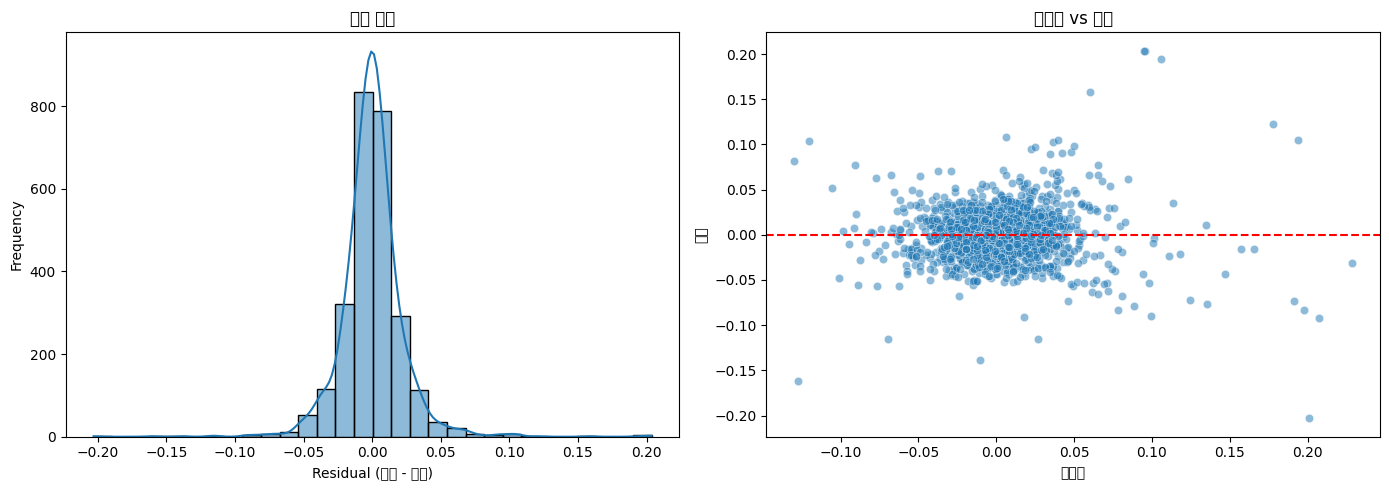

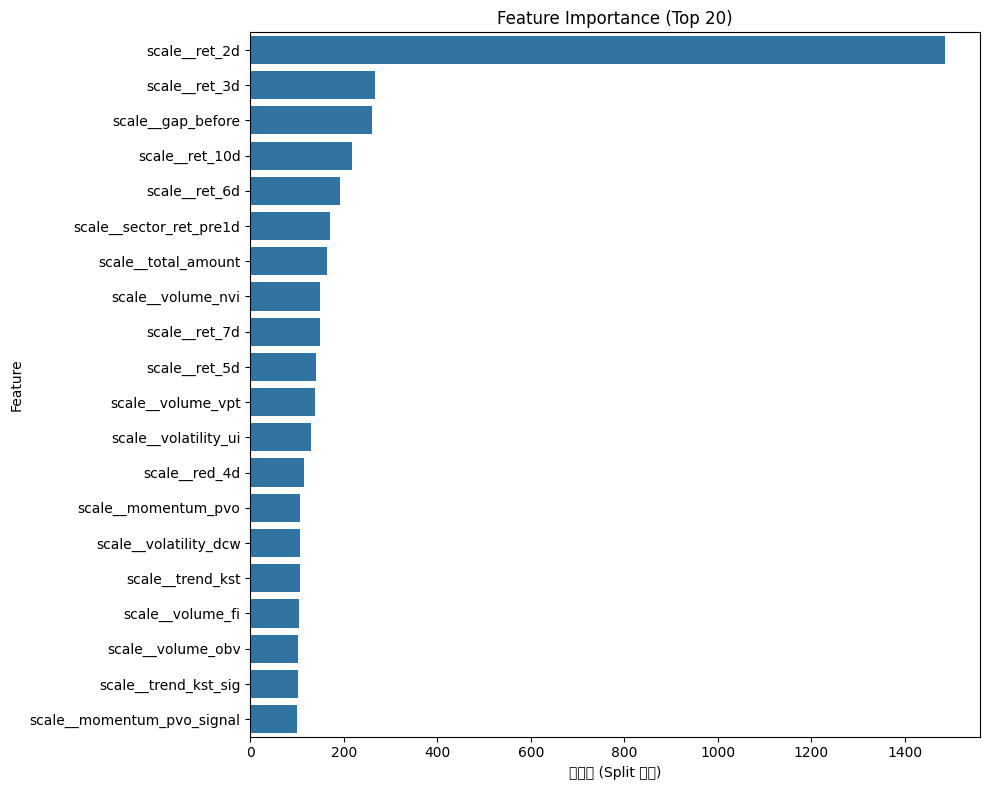

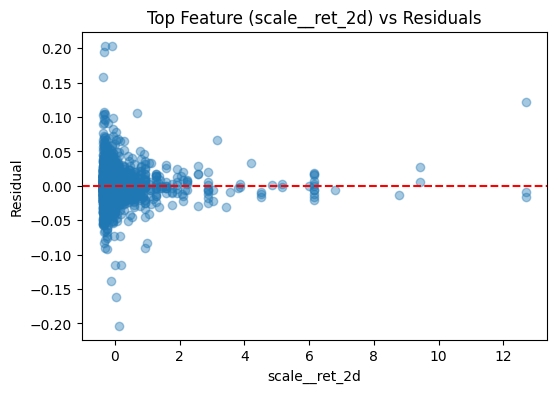

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# ───────────────────────────────────────────────
# 1. 예측 및 잔차 계산
y_pred = pipe.predict(X_test)
residuals = y_test - y_pred

# ───────────────────────────────────────────────
# 2. 잔차 분석 시각화
plt.figure(figsize=(14, 5))

# (1) 잔차 히스토그램
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, bins=30)
plt.title("잔차 분포")
plt.xlabel("Residual (실제 - 예측)")
plt.ylabel("Frequency")

# (2) 예측값 vs 잔차
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("예측값 vs 잔차")
plt.xlabel("예측값")
plt.ylabel("잔차")

plt.tight_layout()
plt.show()

# ───────────────────────────────────────────────
# 3. Feature Importance (훈련 데이터 기준)
model_fi = lgb.LGBMRegressor(**study.best_params, verbose=-1, n_jobs=-1)
model_fi.fit(preprocessor.fit_transform(X_train), y_train)

importances = model_fi.feature_importances_
feature_names = preprocessor.get_feature_names_out()

fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

# 상위 20개 시각화
plt.figure(figsize=(10, 8))
sns.barplot(data=fi_df.head(20), x="Importance", y="Feature")
plt.title("Feature Importance (Top 20)")
plt.xlabel("중요도 (Split 기준)")
plt.tight_layout()
plt.show()

top_feature = fi_df.iloc[0]["Feature"]
plt.figure(figsize=(6, 4))
plt.scatter(preprocessor.transform(X_test)[:, 0], residuals, alpha=0.4)
plt.title(f"Top Feature ({top_feature}) vs Residuals")
plt.xlabel(top_feature)
plt.ylabel("Residual")
plt.axhline(0, color="red", linestyle="--")
plt.show()

In [7]:
import os
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# ───────────────────────────────────────────────────────────────
# [경로 설정]
BASE_DIR   = "/Users/gun/Desktop/미래에셋 AI 공모전/data"
MODEL_DIR  = os.path.join(BASE_DIR, "models")
RESULT_DIR = os.path.join(BASE_DIR, "results", "regression")
DATA_FP    = os.path.join(BASE_DIR, "module_datasets", "regression_enriched.csv")
MODEL_FP   = os.path.join(MODEL_DIR, "lgbm_regressor_base.pkl")
PRED_FP    = os.path.join(RESULT_DIR, "regression_predictions_for_ensemble.csv")

os.makedirs(RESULT_DIR, exist_ok=True)

# ───────────────────────────────────────────────────────────────
# [모델 로딩]
base_pipe = joblib.load(MODEL_FP)

# ───────────────────────────────────────────────────────────────
# [데이터 로딩 및 파생변수 재생성]
df = pd.read_csv(DATA_FP, parse_dates=["rcept_dt"], dtype={"stock_code":str})
df = df.dropna(subset=["ret_1d"])  # 타깃 결측 제거

# (1) ret_2d_clip / log
if "ret_2d" in df.columns:
    q_low, q_hi = df["ret_2d"].quantile([0.01, 0.99])
    df["ret_2d_clip"] = df["ret_2d"].clip(lower=q_low, upper=q_hi)
    df["ret_2d_log"] = np.sign(df["ret_2d_clip"]) * np.log1p(np.abs(df["ret_2d_clip"]))
else:
    df["ret_2d_clip"] = 0.0
    df["ret_2d_log"]  = 0.0

# (2) 상호작용 항목 생성
if {"ret_2d_log", "volume_nvi"}.issubset(df.columns):
    df["ret2d_vol_nvi"] = df["ret_2d_log"] * df["volume_nvi"]
if {"gap_before", "volatility_ui"}.issubset(df.columns):
    df["gap_vol_ui"] = df["gap_before"] * df["volatility_ui"]

# ───────────────────────────────────────────────────────────────
# [입력/타깃 분리]
y = df["ret_1d"].values
X = df.drop(columns=["ret_1d", "stock_code", "rcept_dt", "corp_name"], errors="ignore")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, shuffle=False
)

# ───────────────────────────────────────────────────────────────
# [예측 및 저장]
y_true   = y_test
y_pred   = base_pipe.predict(X_test)
residual = y_true - y_pred

df_out = pd.DataFrame({
    "stock_code": df.loc[X_test.index, "stock_code"].values,
    "rcept_dt":   df.loc[X_test.index, "rcept_dt"].values,
    "y_true":     y_true,
    "y_pred":     y_pred,
    "residual":   residual
})

df_out.to_csv(PRED_FP, index=False, encoding="utf-8-sig")
print(f"✅ 앙상블용 회귀 예측 결과 저장 완료: {PRED_FP}")

✅ 앙상블용 회귀 예측 결과 저장 완료: /Users/gun/Desktop/미래에셋 AI 공모전/data/results/regression/regression_predictions_for_ensemble.csv
